# Setup

In [14]:
using Pkg; Pkg.activate("..")

using VegaLite
using Dates
using Feather
using DataFrames
using DataFramesMeta
using Statistics
using StatsBase
using AuditoryBistabilityLE
using ShammaModel
using AxisArrays
using RCall

srcdir = joinpath("..","src")
include(joinpath(srcdir,"count_lengths.jl"))
plotdir = joinpath("..","plots","individual_sim_$(Date(now()))")
datadir = joinpath("..","data","count_lengths","run_2018-10-04")

@vlplot(:bar, x={:IMDB_Rating, bin=true}, y="count()")

R"options(rcalljl_options=list(width=800,height=400))"

RObject{VecSxp}
$rcalljl_options
$rcalljl_options$width
[1] 800

$rcalljl_options$height
[1] 400




# Load data

In [2]:
params = Feather.read(joinpath(datadir,"individual_levels_params.feather"))
params[:pindex] = 1:size(params,1)

results = []
for_results_in(joinpath(datadir,"data")) do entry
  push!(results,DataFrame(length=entry["lengths"],
                          percepts=entry["percepts"].+1, # after +1, indicates the number of streams reported, 1 or 2
                          created=entry["created"],
                          pindex=entry["pindex"])) # the parameter index (pindex = N correspondes to row N of `params`)
end
df = vcat(results...)

┌ Info: Loading results_params00001_00015.jld2
└ @ Main /Users/davidlittle/googledrive/Work/Software/bistable/src/count_lengths.jl:23
┌ Info: Loading results_params00016_00030.jld2
└ @ Main /Users/davidlittle/googledrive/Work/Software/bistable/src/count_lengths.jl:23
┌ Info: Loading results_params00031_00045.jld2
└ @ Main /Users/davidlittle/googledrive/Work/Software/bistable/src/count_lengths.jl:23
┌ Info: Loading results_params00046_00060.jld2
└ @ Main /Users/davidlittle/googledrive/Work/Software/bistable/src/count_lengths.jl:23
┌ Info: Loading results_params00061_00075.jld2
└ @ Main /Users/davidlittle/googledrive/Work/Software/bistable/src/count_lengths.jl:23
┌ Info: Loading results_params00076_00090.jld2
└ @ Main /Users/davidlittle/googledrive/Work/Software/bistable/src/count_lengths.jl:23
┌ Info: Loading results_params00091_00105.jld2
└ @ Main /Users/davidlittle/googledrive/Work/Software/bistable/src/count_lengths.jl:23
┌ Info: Loading results_params00106_00120.jld2
└ @ Main /Users

,length,percepts,created,pindex
,Float64,Int64,DateTime,Int64
1,47.52,1,2018-10-04T17:17:16.761,1
2,47.52,1,2018-10-04T17:18:24.461,1
3,47.52,1,2018-10-04T17:18:32.578,1
4,47.52,1,2018-10-04T17:18:38.75,1
5,47.52,1,2018-10-04T17:18:44.805,1
6,47.52,1,2018-10-04T17:18:50.969,1
7,47.52,1,2018-10-04T17:18:57.428,1
8,47.52,1,2018-10-04T17:19:03.676,1
9,47.52,1,2018-10-04T17:19:10.056,1


In [3]:
sim_length = jldopen(joinpath(datadir,"data",readdir(joinpath(datadir,"data"))[1]),"r") do first_file
    last(first_file["btimes_s"])
end

47.78

# proportion streaming

In [122]:
function handlebound(fn,seconds;bound=true,threshold=0.8)
    if bound && length(seconds) < 3
        return missing
    end
    
    if !bound || (sum(seconds[2:end-1]) > threshold*sum(seconds))
        fn(1:length(seconds))
    else
        fn(2:length(seconds)-1)
    end
end

handlebound (generic function with 2 methods)

In [123]:
function streamprop(percepts,seconds;kwds...)
    handlebound(seconds;kwds...) do range
        sum(seconds[range][percepts[range] .== 2]) / sum(seconds[range])
    end
end

streamprop (generic function with 1 method)

In [125]:
function stim_per_second(seconds;kwds...)
    handlebound(seconds;kwds...) do range
        length(range) / sim_length
    end
end
        

stim_per_second (generic function with 1 method)

In [126]:
df_summary = @linq df |>
  by(:pindex,
     num_sims = length(unique(:created)),
     stim_rate = stim_per_second(:length),
     skew = skewness(log.(:length)),
     kurt = kurtosis(log.(:length)),
     streamprop = streamprop(:percepts,:length,bound=true)) |>
  join(params,on = :pindex) |>
  transform(f_c_a = round.(:f_c_a), f_c_m = round.(:f_c_m),
            s_c_a = round.(:s_c_a), s_c_m = round.(:s_c_m),
            t_c_a = round.(:t_c_a), t_c_m = round.(:t_c_m))

,pindex,num_sims,stim_rate,skew,kurt,streamprop,f_W_m_σ,f_c_m,t_c_a,t_c_m,f,t_W_m_c,t_c_x,f_c_x,t_W_m_σ_t,s_τ_σ,f_c_a,f_c_σ,s_c_m,f_τ_a,s_c_σ,Δt,s_τ_m,s_c_x,t_W_m_σ_ϕ,t_τ_a,s_c_a,t_τ_m,t_c_σ,t_τ_x,s_W_m_c,s_τ_a,f_W_m_c,t_τ_σ,f_τ_σ,f_τ_x,Δf,t_W_m_σ_N,f_τ_m,s_τ_x,s_W_m_σ
,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Int64,Float64,Float64,Float64,Float64
1,1,20,0.418585,NaN,NaN,0.0,5.6,0.0,0.0,0.0,500.0,6.0,3.0,3.0,7.0,500.0,0.0,0.2,0.0,3000.0,0.0,240.0,350.0,3.0,7.0,3000.0,0.0,350.0,0.0,500.0,6.0,3000.0,6.0,500.0,500.0,500.0,3,3.0,350.0,500.0,15.0
2,2,20,0.418585,NaN,NaN,0.0,5.6,18.0,0.0,0.0,500.0,6.0,3.0,3.0,7.0,500.0,0.0,0.2,0.0,3000.0,0.0,240.0,350.0,3.0,7.0,3000.0,0.0,350.0,0.0,500.0,6.0,3000.0,6.0,500.0,500.0,500.0,3,3.0,350.0,500.0,15.0
3,3,20,0.418585,NaN,NaN,0.0,5.6,32.0,0.0,0.0,500.0,6.0,3.0,3.0,7.0,500.0,0.0,0.2,0.0,3000.0,0.0,240.0,350.0,3.0,7.0,3000.0,0.0,350.0,0.0,500.0,6.0,3000.0,6.0,500.0,500.0,500.0,3,3.0,350.0,500.0,15.0
4,4,20,0.418585,NaN,NaN,0.0,5.6,56.0,0.0,0.0,500.0,6.0,3.0,3.0,7.0,500.0,0.0,0.2,0.0,3000.0,0.0,240.0,350.0,3.0,7.0,3000.0,0.0,350.0,0.0,500.0,6.0,3000.0,6.0,500.0,500.0,500.0,3,3.0,350.0,500.0,15.0
5,5,20,0.418585,NaN,NaN,0.0,5.6,100.0,0.0,0.0,500.0,6.0,3.0,3.0,7.0,500.0,0.0,0.2,0.0,3000.0,0.0,240.0,350.0,3.0,7.0,3000.0,0.0,350.0,0.0,500.0,6.0,3000.0,6.0,500.0,500.0,500.0,3,3.0,350.0,500.0,15.0
6,6,20,0.418585,NaN,NaN,0.0,5.6,0.0,0.0,0.0,500.0,6.0,3.0,3.0,7.0,500.0,5.0,0.2,0.0,3000.0,0.0,240.0,350.0,3.0,7.0,3000.0,0.0,350.0,0.0,500.0,6.0,3000.0,6.0,500.0,500.0,500.0,3,3.0,350.0,500.0,15.0
7,7,20,0.418585,NaN,NaN,0.0,5.6,18.0,0.0,0.0,500.0,6.0,3.0,3.0,7.0,500.0,5.0,0.2,0.0,3000.0,0.0,240.0,350.0,3.0,7.0,3000.0,0.0,350.0,0.0,500.0,6.0,3000.0,6.0,500.0,500.0,500.0,3,3.0,350.0,500.0,15.0
8,8,20,0.418585,NaN,NaN,0.0,5.6,32.0,0.0,0.0,500.0,6.0,3.0,3.0,7.0,500.0,5.0,0.2,0.0,3000.0,0.0,240.0,350.0,3.0,7.0,3000.0,0.0,350.0,0.0,500.0,6.0,3000.0,6.0,500.0,500.0,500.0,3,3.0,350.0,500.0,15.0
9,9,20,0.418585,NaN,NaN,0.0,5.6,56.0,0.0,0.0,500.0,6.0,3.0,3.0,7.0,500.0,5.0,0.2,0.0,3000.0,0.0,240.0,350.0,3.0,7.0,3000.0,0.0,350.0,0.0,500.0,6.0,3000.0,6.0,500.0,500.0,500.0,3,3.0,350.0,500.0,15.0


WARN column encoding should be discrete (ordinal / nominal / binned).
WARN column encoding should be discrete (ordinal / nominal / binned).


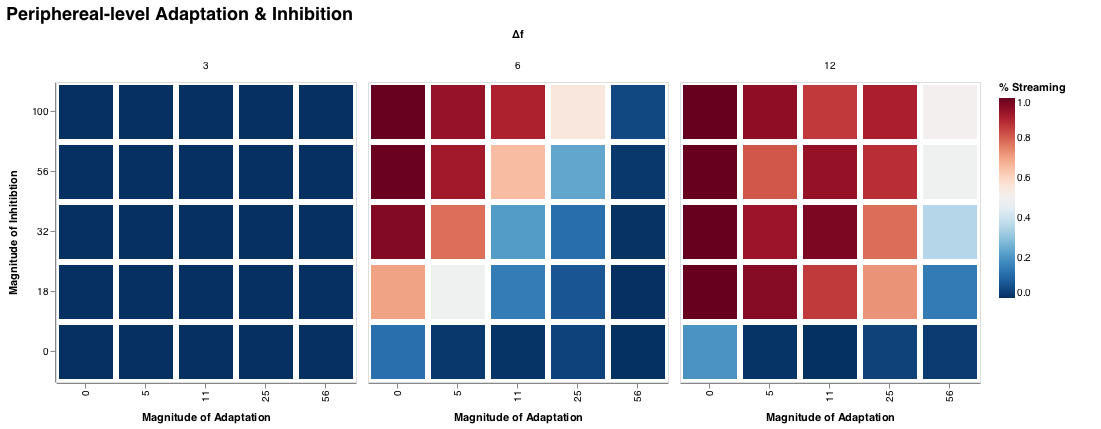

In [113]:
@where(df_summary,:f_c_σ .> 0) |>
  @vlplot(:rect, width=300, height=300,
          title={text="Periphereal-level Adaptation & Inhibition",fontSize=18},
          column=:Δf,
          x={field=:f_c_a, typ="ordinal", sort = "ascending",
             axis={title="Magnitude of Adaptation"}},
          y={field=:f_c_m, typ="ordinal", sort = "descending",
             axis={title="Magnitude of Inhitibtion"}},
          color={field="streamprop", aggregate="mean", typ="quantitative",
                 sort = "descending",scale={domain=[0,1],range="diverging"},
                 legend={title="% Streaming"}},
          config={range={diverging={scheme="redblue"}}})

WARN column encoding should be discrete (ordinal / nominal / binned).
WARN column encoding should be discrete (ordinal / nominal / binned).


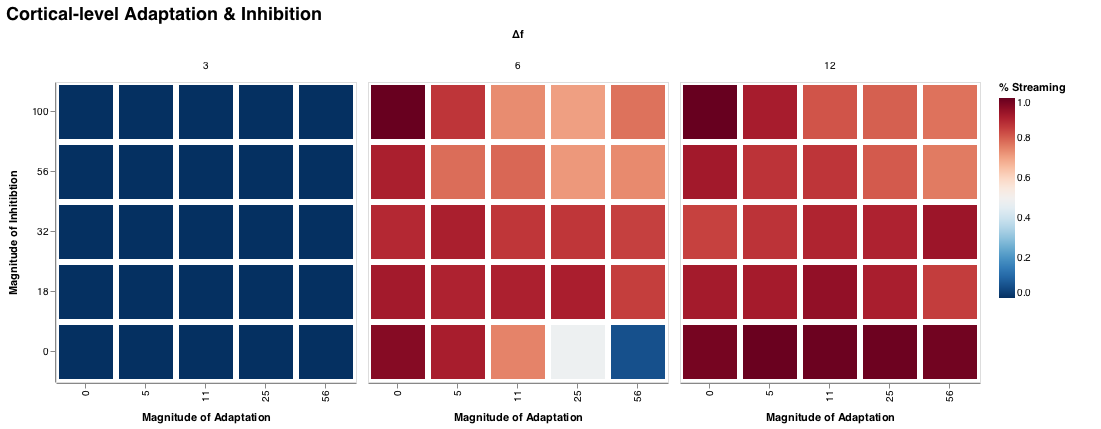

In [114]:
@where(df_summary,:s_c_σ .> 0) |>
  @vlplot(:rect, width=300, height=300,
          title={text="Cortical-level Adaptation & Inhibition",fontSize=18},
          column=:Δf,
          x={field=:s_c_a, typ="ordinal", sort = "ascending",
             axis={title="Magnitude of Adaptation"}},
          y={field=:s_c_m, typ="ordinal", sort = "descending",
             axis={title="Magnitude of Inhitibtion"}},
          color={field="streamprop", aggregate="mean", typ="quantitative",
                 sort = "descending",scale={domain=[0,1],range="diverging"},
                 legend={title="% Streaming"}},
          config={range={diverging={scheme="redblue"}}})

WARN column encoding should be discrete (ordinal / nominal / binned).
WARN column encoding should be discrete (ordinal / nominal / binned).


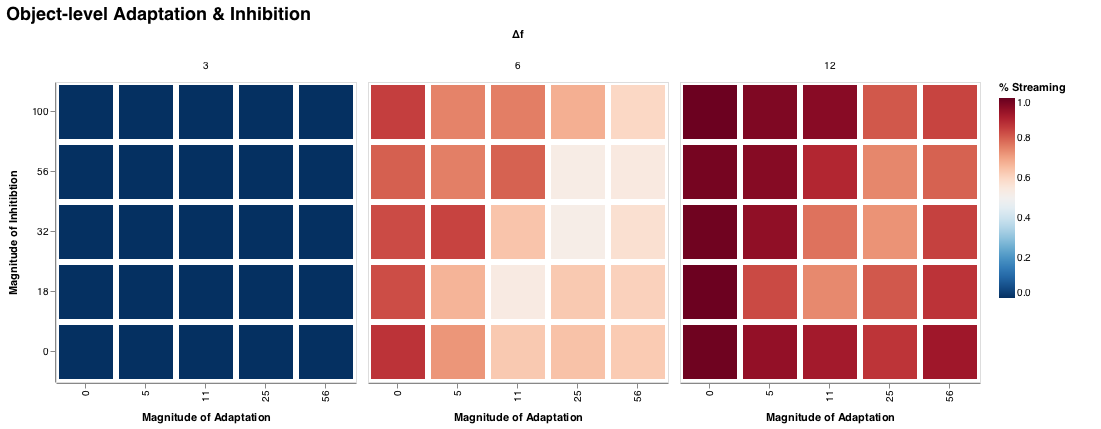

In [115]:
@where(df_summary,:t_c_σ .> 0) |>
  @vlplot(:rect, width=300, height=300,
          title={text="Object-level Adaptation & Inhibition",fontSize=18},
          column=:Δf,
          x={field=:t_c_a, typ="ordinal", sort = "ascending",
             axis={title="Magnitude of Adaptation"}},
          y={field=:t_c_m, typ="ordinal", sort = "descending",
             axis={title="Magnitude of Inhitibtion"}},
          color={field="streamprop", aggregate="mean", typ="quantitative",
                 sort = "descending",scale={domain=[0,1],range="diverging"},
                 legend={title="% Streaming"}},
          config={range={diverging={scheme="redblue"}}})

# RMS of streaming selectivity

In [116]:
mean_human = [0.11, 0.55, 0.89]
function stream_rms(str3,str6,str12)
  vec(sqrt.(mean((hcat(str3,str6,str12) .- mean_human').^2,dims=2)))
end

stream_rms (generic function with 1 method)

In [117]:
function rename_levels_for(df,val)
    df[:c_m] = NaN
    df[:c_a] = NaN
    df[:level] = "unknown"
    @byrow! df begin
        if :f_c_σ > 0 
           :level = "Peripheral"
            :c_m = :f_c_m
            :c_a = :f_c_a
        elseif :s_c_σ > 0 
            :level = "Cortical"
            :c_m = :s_c_m
            :c_a = :s_c_a
        elseif :t_c_σ > 0 
            :level = "Object"
            :c_m = :t_c_m
            :c_a = :t_c_a
        end
    end
    df[[:c_m,:c_a,:level,val]]
end
        
DataFramesMeta.linq(::DataFramesMeta.SymbolParameter{:rename_levels}, df, val) = :(rename_levels($df,$val))

In [118]:
df_stream_rms = @linq df_summary |>
  select(:f_c_σ,:f_c_a,:f_c_m,:s_c_σ,:s_c_a,:s_c_m,:t_c_σ,:t_c_a,:t_c_m,:Δf,:streamprop) |>
  unstack(:Δf,:streamprop) |>
  rename(Symbol("3") => :Δf_3,Symbol("6") => :Δf_6,Symbol("12") => :Δf_12) |>
  transform(stream_rms = stream_rms(:Δf_3,:Δf_6,:Δf_12)) |>
  rename_levels_for(:stream_rms)

,c_m,c_a,level,stream_rms
,Float64,Float64,String,Float64
1,0.0,0.0,Object,0.201261
2,18.0,0.0,Object,0.181737
3,32.0,0.0,Object,0.181854
4,56.0,0.0,Object,0.165615
5,100.0,0.0,Object,0.192955
6,0.0,5.0,Object,0.120309
7,18.0,5.0,Object,0.100036
8,32.0,5.0,Object,0.181925
9,56.0,5.0,Object,0.140018


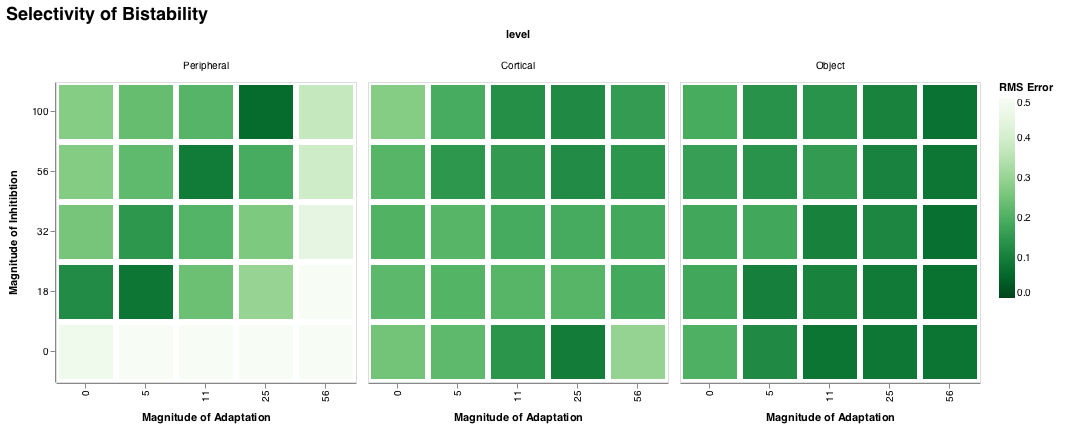

In [119]:
df_stream_rms |>
  @vlplot(:rect, width=300, height=300,
          title={text="Selectivity of Bistability",fontSize=18},
          column={field=:level, typ="nominal", sort=["Peripheral", "Cortical", "Object"]},
          x={field=:c_a, typ="ordinal", sort = "ascending",
             axis={title="Magnitude of Adaptation"}},
          y={field=:c_m, typ="ordinal", sort = "descending",
             axis={title="Magnitude of Inhitibtion"}},
          color={field="stream_rms", aggregate="mean", typ="quantitative", sort = "descending",
                 legend={title="RMS Error"}, scale={domain=[0,0.5]}},
          config={range={heatmap={scheme="greens"}}})

# Count

In [150]:
df_stim_rate = @linq df_summary |>
  where(:Δf .== 6) |>
  select(:f_c_σ,:f_c_a,:f_c_m,:s_c_σ,:s_c_a,:s_c_m,:t_c_σ,:t_c_a,:t_c_m,:stim_rate) |>
  rename_levels_for(:stim_rate);

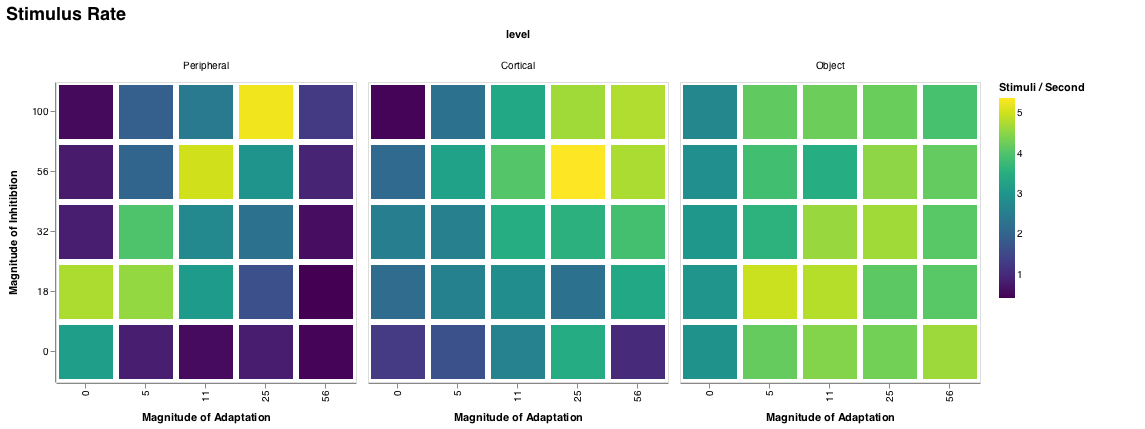

In [135]:
df_stim_rate |>
  @vlplot(:rect, width=300, height=300,
          title={text="Stimulus Rate",fontSize=18},
          column={field=:level, typ="nominal", sort=["Peripheral", "Cortical", "Object"]},
          x={field=:c_a, typ="ordinal", sort = "ascending",
             axis={title="Magnitude of Adaptation"}},
          y={field=:c_m, typ="ordinal", sort = "descending",
             axis={title="Magnitude of Inhitibtion"}},
          color={field=:stim_rate, aggregate="mean", typ="quantitative", 
                 legend={title="Stimuli / Second"}},
          config={range={heatmap={scheme="viridis"}}})

# Log Normality

In [151]:
df_skew = @linq df_summary |>
  where(:Δf .== 6) |>
  select(:f_c_σ,:f_c_a,:f_c_m,:s_c_σ,:s_c_a,:s_c_m,:t_c_σ,:t_c_a,:t_c_m,:skew) |>
  rename_levels_for(:skew);

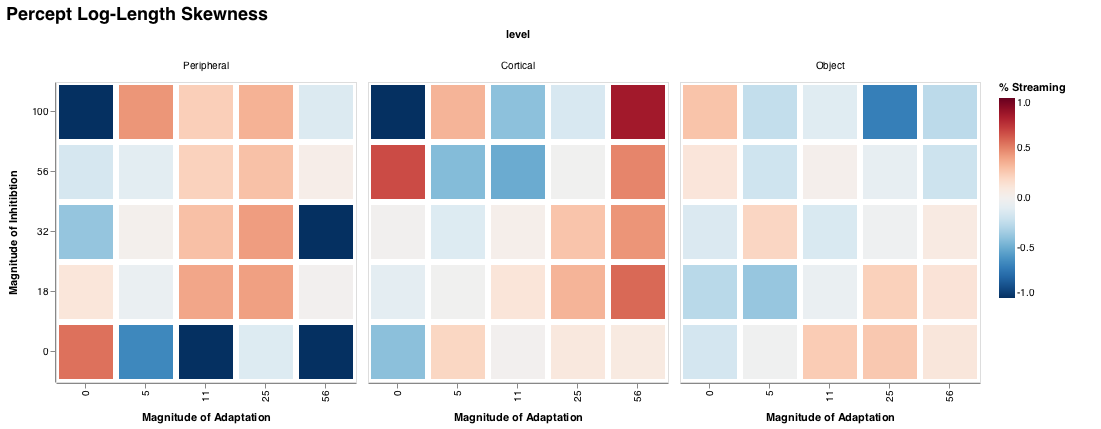

In [143]:
df_skew |>
  @vlplot(:rect, width=300, height=300,
          title={text="Percept Log-Length Skewness",fontSize=18},
          column={field=:level, typ="nominal", sort=["Peripheral", "Cortical", "Object"]},
          x={field=:c_a, typ="ordinal", sort = "ascending",
             axis={title="Magnitude of Adaptation"}},
          y={field=:c_m, typ="ordinal", sort = "descending",
             axis={title="Magnitude of Inhitibtion"}},
          color={field="skew", aggregate="mean", typ="quantitative",
                 sort = "descending",scale={domain=[-1,1],range="diverging"},
                 legend={title="% Streaming"}},
          config={range={diverging={scheme="redblue"}}})

# Kurtosis

In [152]:
df_kurt = @linq df_summary |>
  where(:Δf .== 6) |>
  select(:f_c_σ,:f_c_a,:f_c_m,:s_c_σ,:s_c_a,:s_c_m,:t_c_σ,:t_c_a,:t_c_m,:kurt) |>
  rename_levels_for(:kurt);

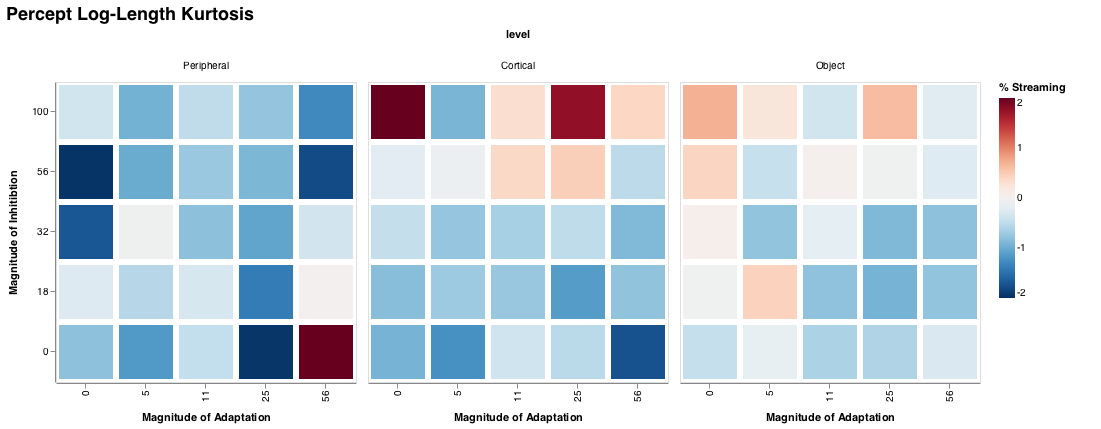

In [149]:
df_kurt |>
  @vlplot(:rect, width=300, height=300,
          title={text="Percept Log-Length Kurtosis",fontSize=18},
          column={field=:level, typ="nominal", sort=["Peripheral", "Cortical", "Object"]},
          x={field=:c_a, typ="ordinal", sort = "ascending",
             axis={title="Magnitude of Adaptation"}},
          y={field=:c_m, typ="ordinal", sort = "descending",
             axis={title="Magnitude of Inhitibtion"}},
          color={field="kurt", aggregate="mean", typ="quantitative",
                 sort = "descending",scale={domain=[-2,2],range="diverging"},
                 legend={title="% Streaming"}},
          config={range={diverging={scheme="redblue"}}})

# Overal RMS

In [206]:
rms(x) = any(isnan,x) ? 100 : sqrt(mean(x.^2))

rms (generic function with 3 methods)

In [207]:
df_combined = join(df_stream_rms,df_skew,on = [:c_m,:c_a,:level])
df_combined = join(df_combined,df_kurt,on = [:c_m,:c_a,:level])
df_combined = @transform(df_combined,rms = vec(mapslices(rms,[:stream_rms :skew :kurt],dims=2)))

,c_m,c_a,level,stream_rms,skew,kurt,rms
,Float64,Float64,String,Float64,Float64,Float64,Float64
1,0.0,0.0,Object,0.201261,-0.170259,-0.45011,0.301161
2,18.0,0.0,Object,0.181737,-0.271475,-0.047578,0.190605
3,32.0,0.0,Object,0.181854,-0.140128,0.0574629,0.136637
4,56.0,0.0,Object,0.165615,0.116166,0.417409,0.267802
5,100.0,0.0,Object,0.192955,0.281363,0.700055,0.44962
6,0.0,5.0,Object,0.120309,-0.0257084,-0.13759,0.106562
7,18.0,5.0,Object,0.100036,-0.378751,0.441117,0.340609
8,32.0,5.0,Object,0.181925,0.203107,-0.777163,0.475511
9,56.0,5.0,Object,0.140018,-0.189319,-0.444135,0.290231


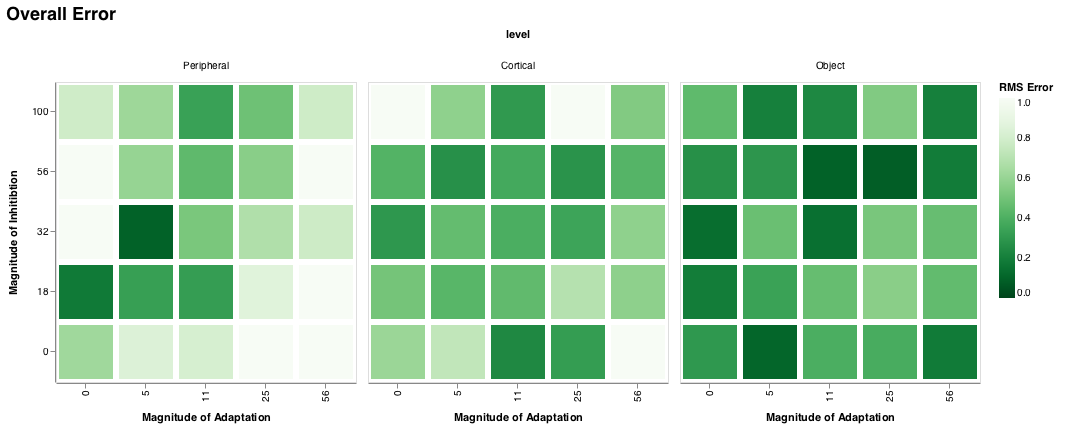

In [208]:
df_combined |>
  @vlplot(:rect, width=300, height=300,
          title={text="Overall Error",fontSize=18},
          column={field=:level, typ="nominal", sort=["Peripheral", "Cortical", "Object"]},
          x={field=:c_a, typ="ordinal", sort = "ascending",
             axis={title="Magnitude of Adaptation"}},
          y={field=:c_m, typ="ordinal", sort = "descending",
             axis={title="Magnitude of Inhitibtion"}},
          color={field="rms", aggregate="mean", typ="quantitative", sort="descending",
                 legend={title="RMS Error"}, scale={domain = [0,1]}},
          config={range={heatmap={scheme="greens"}},
                  invalidValues="filter"})

# individual trials

In [4]:
selection = @where(params,(abs.(:f_c_m .- 32) .< 1) .& (abs.(:f_c_a .- 5) .< 1) .& (:Δf .== 6))[:pindex][1]

33

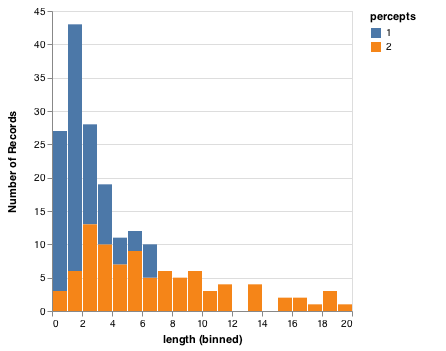

In [5]:
@where(df,(:pindex .== selection) .& (:length .< 20)) |>
   @vlplot(:bar, width=300, height=300, x={:length, bin={step=1.0}}, y="count()",
           color={field=:percepts, typ="nominal"})

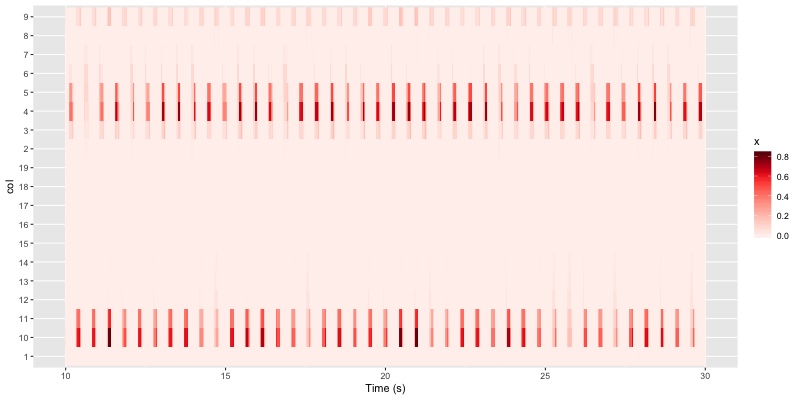

RObject{VecSxp}


In [28]:
masks = []
for_results_in(joinpath(datadir,"data")) do entry
    if entry["pindex"] == selection
        push!(masks,entry["mask"])
    end
end

rplot(AuditoryBistabilityLE.decompress(masks[1])[10s .. 30s])

In [17]:
selection = @where(params,(abs.(:s_c_m .- 0) .< 1) .& (abs.(:s_c_a .- 11) .< 1) .& (:Δf .== 6))[:pindex][1]

111

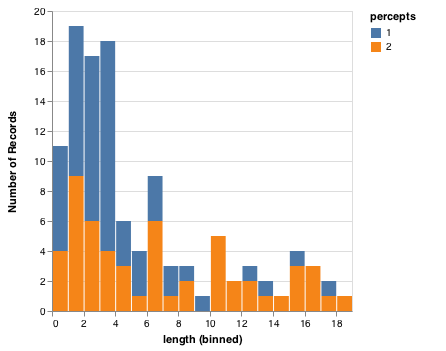

In [18]:
@where(df,(:pindex .== selection) .& (:length .< 20)) |>
   @vlplot(:bar, width=300, height=300, x={:length, bin={step=1.0}}, y="count()",
           color={field=:percepts, typ="nominal"})

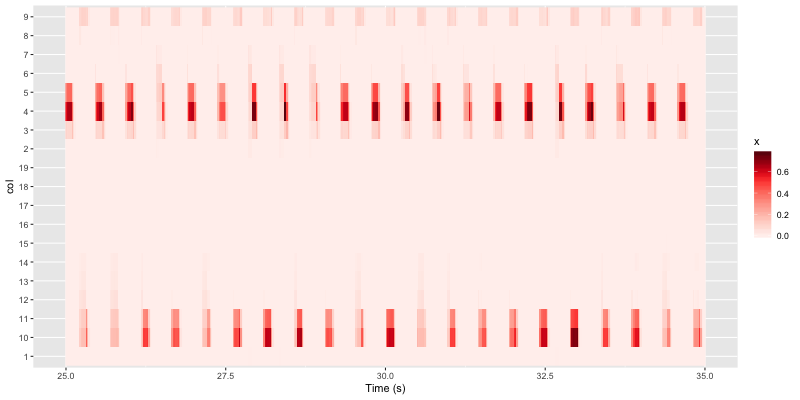

RObject{VecSxp}


In [27]:
masks = []
for_results_in(joinpath(datadir,"data")) do entry
    if entry["pindex"] == selection
        push!(masks,entry["mask"])
    end
end

rplot(AuditoryBistabilityLE.decompress(masks[1])[25s .. 35s])

In [21]:
selection = @where(params,(abs.(:t_c_m .- 0) .< 1) .& (abs.(:t_c_a .- 11) .< 1) .& (:Δf .== 6))[:pindex][1]

178

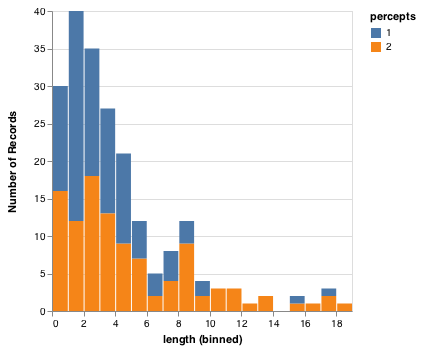

In [22]:
@where(df,(:pindex .== selection) .& (:length .< 20)) |>
   @vlplot(:bar, width=300, height=300, x={:length, bin={step=1.0}}, y="count()",
           color={field=:percepts, typ="nominal"})

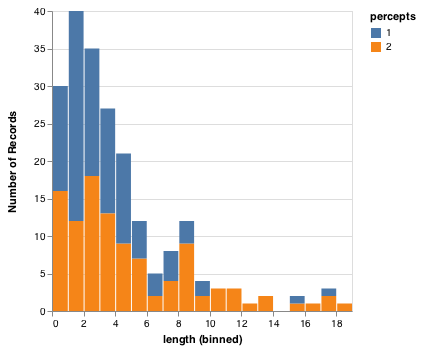

In [32]:
@where(df,(:pindex .== selection) .& (:length .< 20)) |>
   @vlplot(:bar, width=300, height=300, x={:length, bin={step=1.0}}, y="count()",
           color={field=:percepts, typ="nominal"})

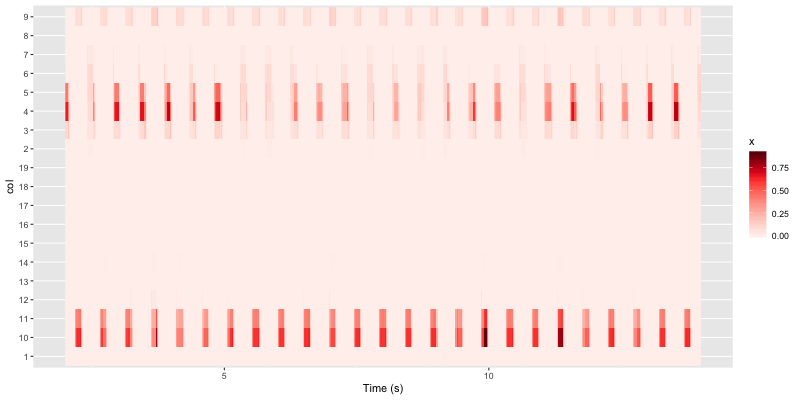

RObject{VecSxp}


In [26]:
masks = []
for_results_in(joinpath(datadir,"data")) do entry
    if entry["pindex"] == selection
        push!(masks,entry["mask"])
    end
end

rplot(AuditoryBistabilityLE.decompress(masks[1])[2s .. 14s])

# Thought

Okay... that all looks encouraging. Next steps:

1. Why does bistability arise with no adaptation for the scale-level? (or the object level?)
2. In parallel, look at the context condtion
3. start running the interaction condition